### 0. Imports

In [1]:
import pandas as pd

from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

### 1. Load and Prepare Data

In [2]:
demand = pd.read_csv('../data/full_pge_demand.csv')

In [3]:
# convert datetime string to period object
demand['utc'] = [pd.Period(period, freq='H') for period in demand['utc']]

### 2. EDA for Modeling

#### 2a) Seasonality

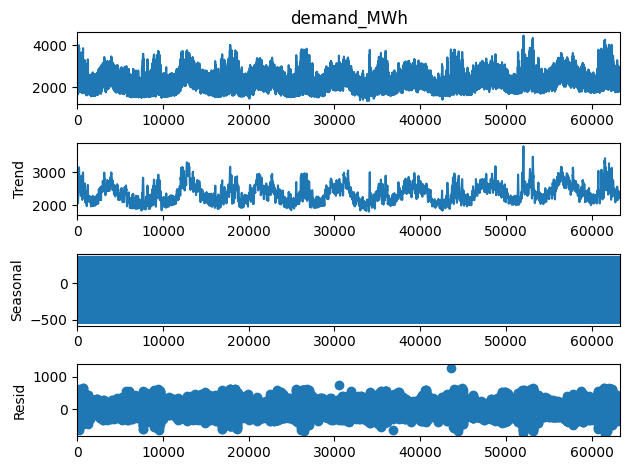

In [4]:
# daily periodicity
seasonal_decompose(demand['demand_MWh'], period=24).plot();

When accounting for daily periodicity, the trend line appears similar to the original series because the most apparent seasonality is annual. The trend is like the daily version of the series, while the seasonal is not interpretable but should show the daily variation pattern.

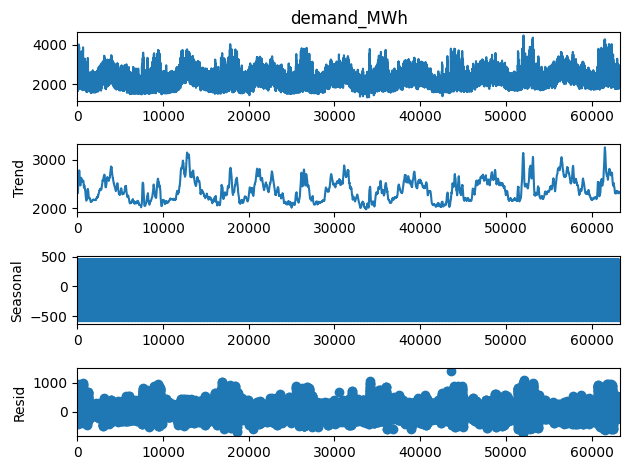

In [5]:
# weekly periodicity
seasonal_decompose(demand['demand_MWh'], period=168).plot();

When accounting for weekly periodicity, the trend line appears similar to the original series, again because the main periodicity is annual. The trend is like the weekly version of the series, while the seasonal graph is uninterpretable but should show the weekly variation pattern.

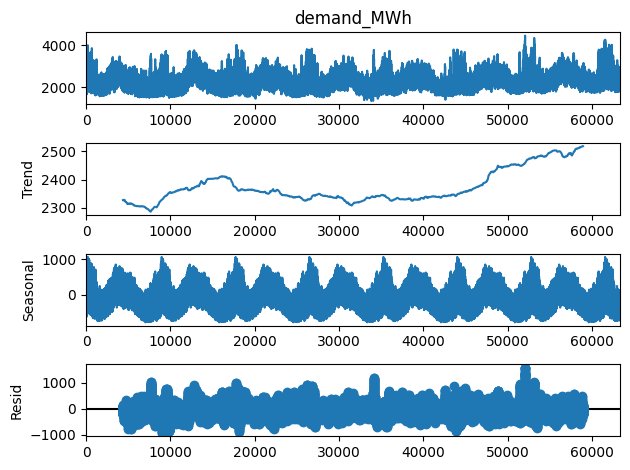

In [6]:
# annual periodicity
seasonal_decompose(demand['demand_MWh'], period=8760).plot();

When accounting for annual periodicity, the trend graph shows no remaining periodicity but instead an irregular and somewhat positive trend. In the seasonal graph, steeper peaks are summers (2015-2022) while more gradual peaks are winters (2015/16 - 2021/22) and troughs are springs and falls.

#### 2b) Autocorrelation

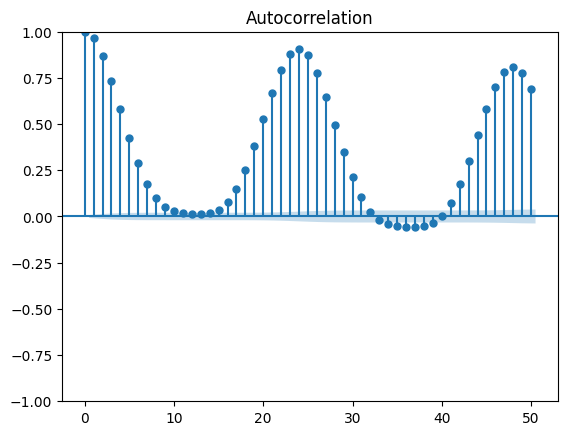

In [7]:
plot_acf(demand['demand_MWh'], lags=50);

The ACF plot shows clear autocorrelation and periodic (daily) autocorrelation.

C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


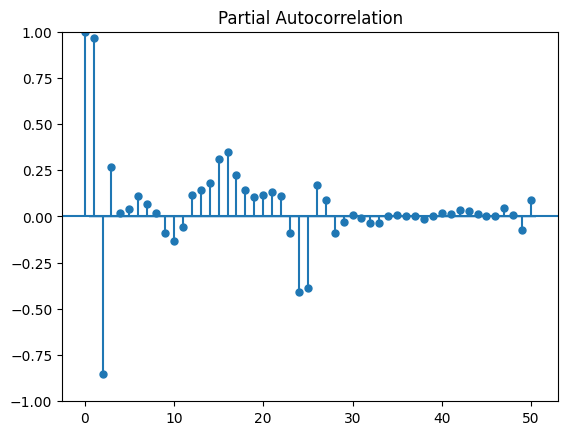

In [8]:
plot_pacf(demand['demand_MWh'], lags=50, alpha=.01);

Even with alpha=0.01, confidence intervals for significance of partial correlations are so narrow that we cannot see them on this graph. They become perceptible for alpha values smaller than 0.00001. That is, even after accounting for numerous more proximate lags, those up to 50 hours behind provide useful information in predicting current demand. It is impractical to include so many lags in model fitting, but those most notable are t-1, t-2, t-24, and t-25, suggesting an autoregressive and seasonal model, as expected.

#### 2c) Stationarity Test: Augmented Dickey-Fuller

In [9]:
adf_results = adfuller(demand['demand_MWh'])

In [10]:
adf_results

(-15.023656890930864,
 1.0137561179364558e-27,
 61,
 63236,
 {'1%': -3.4304534152297728,
  '5%': -2.861585707618533,
  '10%': -2.5667943286169415},
 637231.23920363)

- Test Statistic: -15.0
- p-value: 0.000
- Number of Lags Used: 61
- Number of Observations Used: 63236

From the p-value of basically zero, the series is clearly not stationary. Differencing will likely be an important part of finding the best ARIMA model.

### 3. Auto-ARIMA Fitting

In [11]:
auto = auto_arima(demand['demand_MWh'][:8760],
                  start_p=1, start_q=1,
                  d=1, m=24,
                  trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=21.22 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=108530.625, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=inf, Time=8.51 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=95692.568, Time=7.94 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=108528.626, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=101120.058, Time=0.59 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=18.91 sec
 ARIMA(0,1,1)(0,0,2)[24] intercept   : AIC=93259.323, Time=51.11 sec
 ARIMA(0,1,1)(1,0,2)[24] intercept   : AIC=inf, Time=131.64 sec
 ARIMA(0,1,0)(0,0,2)[24] intercept   : AIC=96833.390, Time=47.04 sec
 ARIMA(1,1,1)(0,0,2)[24] intercept   : AIC=91551.685, Time=63.91 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=93148.853, Time=9.59 sec
 ARIMA(1,1,1)(1,0,2)[24] intercept   : AIC=inf, Time=131.85 sec
 ARIMA(1,1,0)(0,0,2)[24] intercept   : AIC=91768.299, Time=55.37 sec
 ARIMA(2,1,1)(0,0,2)[2

ARIMA(0,1,5)(0,0,2)[24] (no intercept): AIC=91414.060, Time=25.21 sec

In [12]:
auto_12week = auto_arima(demand['demand_MWh'][:2016],
                  start_p=1, start_q=1,
                  d=1, m=24,
                  trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=19716.996, Time=4.79 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=24895.949, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=inf, Time=2.81 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=21783.239, Time=2.04 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=24893.949, Time=0.00 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=20971.705, Time=2.02 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=19984.191, Time=2.81 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,1,1)(2,0,1)[24] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", l

 ARIMA(1,1,1)(2,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,1,1)(1,0,2)[24] intercept   : AIC=inf, Time=28.99 sec
 ARIMA(1,1,1)(0,0,0)[24] intercept   : AIC=21881.787, Time=0.19 sec
 ARIMA(1,1,1)(0,0,2)[24] intercept   : AIC=20587.108, Time=14.61 sec
 ARIMA(1,1,1)(2,0,0)[24] intercept   : AIC=19920.690, Time=24.59 sec
 ARIMA(1,1,1)(2,0,2)[24] intercept   : AIC=inf, Time=45.30 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=20014.549, Time=4.47 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=3.53 sec
 ARIMA(2,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=8.27 sec
 ARIMA(1,1,2)(1,0,1)[24] intercept   : AIC=19708.032, Time=7.59 sec
 ARIMA(1,1,2)(0,0,1)[24] intercept   : AIC=20964.215, Time=2.74 sec
 ARIMA(1,1,2)(1,0,0)[24] intercept   : AIC=19975.878, Time=3.93 sec
 ARIMA(1,1,2)(2,0,1)[24] intercept   : AIC=inf, Time=46.11 sec
 ARIMA(1,1,2)(1,0,2)[24] intercept   : AIC=inf, Time=43.24 sec
 ARIMA(1,1,2)(0,0,0)[24] intercept   : AIC=21869.839, Time=0.46 sec
 ARIMA(1,1,2)(0,0

C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,1,3)(1,0,1)[24] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", l

 ARIMA(2,1,3)(1,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,1,3)(1,0,1)[24] intercept   : AIC=19714.302, Time=11.00 sec
 ARIMA(3,1,1)(1,0,1)[24] intercept   : AIC=19709.130, Time=7.59 sec
 ARIMA(3,1,3)(1,0,1)[24] intercept   : AIC=inf, Time=16.02 sec
 ARIMA(2,1,2)(1,0,1)[24]             : AIC=19651.793, Time=6.01 sec
 ARIMA(2,1,2)(0,0,1)[24]             : AIC=20665.814, Time=2.94 sec
 ARIMA(2,1,2)(1,0,0)[24]             : AIC=inf, Time=5.08 sec
 ARIMA(2,1,2)(2,0,1)[24]             : AIC=inf, Time=39.73 sec
 ARIMA(2,1,2)(1,0,2)[24]             : AIC=inf, Time=42.40 sec
 ARIMA(2,1,2)(0,0,0)[24]             : AIC=21532.541, Time=0.47 sec
 ARIMA(2,1,2)(0,0,2)[24]             : AIC=inf, Time=22.99 sec
 ARIMA(2,1,2)(2,0,0)[24]             : AIC=inf, Time=17.32 sec
 ARIMA(2,1,2)(2,0,2)[24]             : AIC=inf, Time=52.68 sec
 ARIMA(1,1,2)(1,0,1)[24]             : AIC=19706.032, Time=4.04 sec
 ARIMA(2,1,1)(1,0,1)[24]             : AIC=inf, Time=4.57 sec
 ARIMA(3,1,2)(1,0,1)[24]    

ARIMA(2,1,2)(1,0,1)[24] (no intercept): AIC=19651.793, Time=6.01 sec